In [ ]:
# Clone Assamese Tokenizer GitHub repo
!git clone https://github.com/KashyapKishore/AssameseTokenizer.git

# Add repo to Python path and import
import sys
sys.path.append("/content/AssameseTokenizer")

from assamesetokenizer import tokenize_assamese, preprocess_text
as_tokenizer = tokenize_assamese

# Core libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping

fatal: destination path 'AssameseTokenizer' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the original CSV
df = pd.read_csv('/content/drive/MyDrive/new 1.csv', header=None)
df.columns = ['text', 'sentiment']
df.dropna(inplace=True)

# Clean text (remove non-Assamese chars, etc.)
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\u0980-\u09ff\s]', '', x))
df['text'] = df['text'].str.replace('rt', '', regex=False)
df.drop_duplicates(subset='text', inplace=True)

from assamesetokenizer import tokenize_assamese

df['tokens'] = df['text'].apply(tokenize_assamese)

In [ ]:
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\u0980-\u09ff\s]', '', x))
df['text'] = df['text'].str.replace('rt', '', regex=False)
df.drop_duplicates(subset='text', inplace=True)


# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# Filter out classes with fewer than 2 samples
class_counts = df['label'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['label'].isin(valid_classes)]


# Balance classes
min_class_size = df['label'].value_counts().min()
balanced_df = pd.concat([
    resample(df[df['label'] == i], replace=True, n_samples=min_class_size, random_state=42)
    for i in df['label'].unique()
])
balanced_df = balanced_df.sample(frac=1, random_state=42)

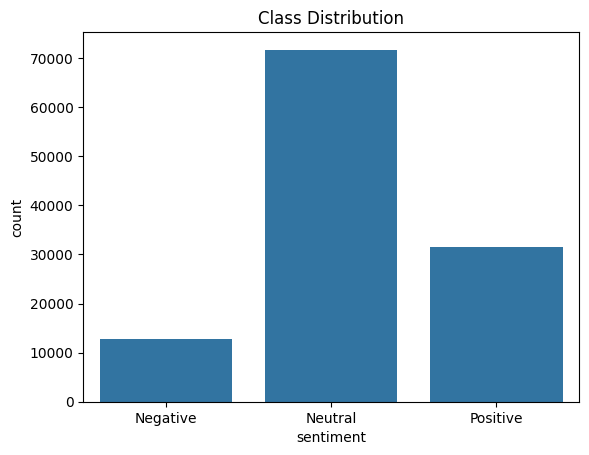

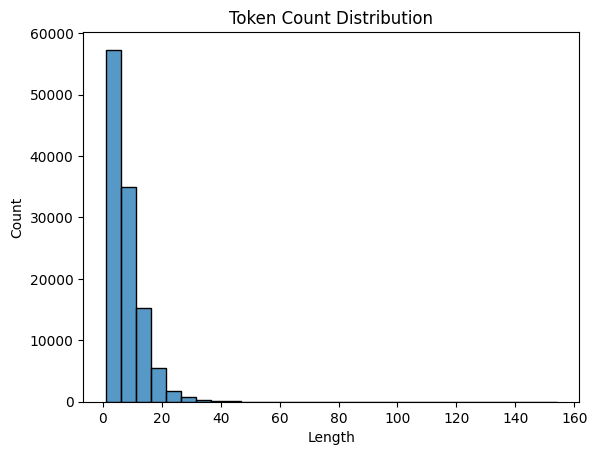

Max token length: 154
95th percentile length: 18.0


In [ ]:
# Sentiment class distribution
sns.countplot(x='sentiment', data=df)
plt.title("Class Distribution")
plt.show()

# Sequence length
df['seq_len'] = df['tokens'].apply(len)
sns.histplot(df['seq_len'], bins=30)
plt.title("Token Count Distribution")
plt.xlabel("Length")
plt.show()

print("Max token length:", df['seq_len'].max())
print("95th percentile length:", df['seq_len'].quantile(0.95))

In [ ]:
# Build vocabulary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Join tokens for Keras Tokenizer
texts = balanced_df['tokens'].apply(lambda x: ' '.join(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index


# Padding
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len)
y = pd.get_dummies(balanced_df['label']).values

In [ ]:
# --- Load FastText Assamese Embeddings ---
# Download from https://fasttext.cc/docs/en/crawl-vectors.html if not already present
# Place the .vec or .bin file in your drive and set the path below
!pip install --upgrade gensim
from gensim.models import KeyedVectors
import os

fasttext_path = '/content/drive/MyDrive/cc.as.300.vec'  # Update this path to your FastText Assamese .vec file
embedding_dim = 300  # FastText vectors are usually 300d

if os.path.exists(fasttext_path):
    ft_model = KeyedVectors.load_word2vec_format(fasttext_path)
    print('FastText loaded')
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in ft_model:
            embedding_matrix[i] = ft_model[word]
else:
    print('FastText Assamese vectors not found, using random embeddings.')
    embedding_matrix = None
    embedding_dim = 128

FastText loaded


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Join tokens for Keras Tokenizer
texts = balanced_df['tokens'].apply(lambda x: ' '.join(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len)
y = pd.get_dummies(balanced_df['label']).values

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

# Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Model definition
input_ = Input(shape=(max_len,))

if embedding_matrix is not None:
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_)
else:
    x = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_)

x = SpatialDropout1D(0.3)(x)

# Apply L2 to LSTM and Dense layers
l2 = regularizers.l2(0.001)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2, recurrent_regularizer=l2))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2, recurrent_regularizer=l2))(x)
x = Dropout(0.5)(x)

x = Attention()(x)

x = Dense(64, activation='relu', kernel_regularizer=l2)(x)
output = Dense(y.shape[1], activation='softmax', kernel_regularizer=l2)(x)

model = Model(inputs=input_, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 92, 300)        │     9,570,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 92, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 92, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 92, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 92, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 92, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 92, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,183,343 (38.85 MB)

 Trainable params: 10,182,831 (38.84 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# --- Batch size tuned for dataset size and Colab TPU/GPU ---
batch_size = 600  # Acceptable if memory allows; can drop to 128/256 for more stability

# --- Model training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)


Epoch 1/10


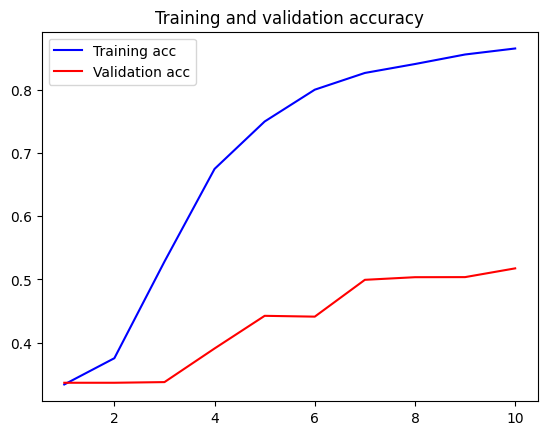

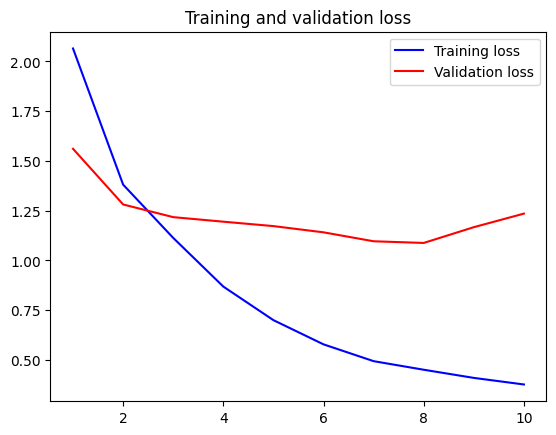

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

    Negative       0.53      0.65      0.58      2582
     Neutral       0.51      0.34      0.41      2600
    Positive       0.47      0.52      0.50      2543

    accuracy                           0.50      7725
   macro avg       0.50      0.50      0.50      7725
weighted avg       0.50      0.50      0.50      7725



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 3, does not match size of target_names, 4
  warnings.warn(


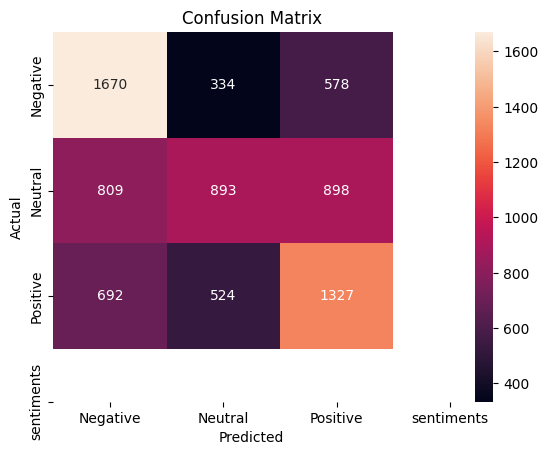

In [ ]:
# --- Step 4: Evaluation ---
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get the unique sorted labels from the balanced dataframe
labels = sorted(balanced_df['label'].unique())

print(classification_report(y_true, y_pred, target_names=le.classes_, labels=labels))

sns.heatmap(confusion_matrix(y_true, y_pred, labels=labels), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
folder_path = '/content/drive/MyDrive/Corpus'
os.makedirs(folder_path, exist_ok=True)

model_path = os.path.join(folder_path, 'ASSAMESE_SENTIMENT_ANALYSIS.h5')
model.save(model_path)
